<a href="https://colab.research.google.com/github/ijnuegnaj/RAG_PRACTICE/blob/practice9/%EC%97%90%EC%9D%B4%EC%A0%84%ED%8A%B8_%ED%88%B4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install langgraph langchain-openai

  Using cached langgraph-0.6.4-py3-none-any.whl.metadata (6.8 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.2/153.2 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.3/74.3 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 443.5/443.5 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.6/50.6 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.5/216.5 kB 15.7 MB/s eta 0:00:00
  Attempting uninstall: langchain-core
    Found existing installation: langchain-core 0.3.72
    Uninstalling langchain-core-0.3.72:
      Successfully uninstalled langchain-core-0.3.72


In [ ]:
#상태에 대한 정의
from typing import TypedDict #상태(State)가 가져야할 정보의 데이터 타입을 고정
from langgraph.graph import StateGraph, START, END

#상태(State)를 클래스로 만듦
class StateSchema(TypedDict):
  request : str
  email : str

#상태는 전체 그래프와 연결
workflow = StateGraph(StateSchema) #StateGraph라는 랭그래프에 StateSchema라는 상태를 붙이시오.

In [ ]:
import os
from google.colab import userdata

os.environ['OPENAI_API_KEY'] = userdata.get('ssu')

In [ ]:
#에이전트와(agents), 도구(tool)을 실제로 연결
#tool이 여러 개 -> Agent가 질문을 파악(LLM) -> 어떤 툴을 실행시킬지 정함
from langchain.agents import AgentExecutor, create_tool_calling_agent
#챗봇 제작을 위한 클래스
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
#툴 제작을 위한 임포트
from langchain.tools import tool
from langchain.chat_models import init_chat_model #챗 모델을 셋업할 때, 툴을 묶어줌
#@(at, 데코레이터) : 함수나, 클래스에 '기능을 추가하겠습니다' 하는 약속
#tool로 명시된 함수는 tool의 기능에 대해 닥스트링(설명)을 꼭 가져야 함
@tool
def write_email(to:str, subject:str, content:str) -> str:
  """Write and Send an email."""
  return f"Email sent to {to} with subejct {subject} and content {content}"
#llm이 위의 툴을 실행함
llm = init_chat_model("openai:gpt-4.1", temperature=0)
#위의 llm 모델에 tool을 묶어줌
#tool_choicee는 bind_tools로 묶어준 tool에 대한 사용 판단 any(필요하면 아무거나 갖다 써), auto(자동 판단), none(쓰지 마)
model_with_tools = llm.bind_tools([write_email], tool_choice='any')

In [ ]:
def write_email_node(state:StateSchema)->StateSchema:

  output = model_with_tools.invoke(state['request'])

  #tool이 추출해낸 to,subject,content
  args = output.tool_calls[0]['args']

  email = write_email(args)
  return {'email':email}


In [ ]:
#노드의 위의 함수를 입력해줌
#add_node(노드 이름, 실제로 실행되는 함수)
workflow.add_node('write_email_node', write_email_node)

workflow.add_edge(START, 'write_email_node')
workflow.add_edge('write_email_node', END)

app = workflow.compile()

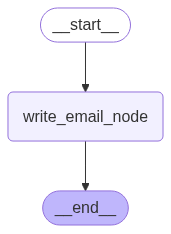

In [ ]:
from IPython.display import Image, display
try:
  #우리가 만든 app의 graph를 이미지로 그려서 display()로 감싸 출력하는 함수
  display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
  pass

In [ ]:
#START -> LLM -> (조건 판단) -> tool -> END
#                            -> ------> END
from typing import Literal
from langgraph.graph import MessagesState
#판단하는 LLM
def call_LLM(state:MessagesState) -> MessagesState:
  """Run LLM"""
  output = model_with_tools.invoke(state['messages'])
  return {'messages': [output]}
def run_tool(state:MessagesState) -> MessagesState:
  """Play the tool"""
  result = []
  for tool_call in state['messages'][-1].tool_calls:
    #tool_call['args'] -> to, sub, content를 딕셔너리 형태로 추출
    observations = write_email.invoke(tool_call['args'])
    #툴을 썼다면 썼다고 전체 히스토리에 남김
    result.append({'role':'tool', 'content':observations, 'tool_call_id':tool_call['id']})
    return {'messages': result}

In [ ]:
#START -> LLM -> (조건 판단) -> tool -> END
#                            -> ------> END
def continue_flow(state:MessagesState) -> Literal['run_tool', '__end__']:
  """Route to tool handler or end if don't need tool calls"""
  message = state['messages']
  latest = message[-1]
  if latest.tool_calls:
    return 'run_tool'
  else:
    return END

In [ ]:
##노드 생성, 엣지 연결
#전체 플로우를 셋업할 StateGraph 정의
workflow = StateGraph(MessagesState)
#2. 노드 등록
workflow.add_node('call_llm', call_LLM)
workflow.add_node('run_tool', run_tool)
#3. 엣지 연결
#START -> LLM -> (조건 판단) -> tool -> END
#                            -> ------> END
workflow.add_edge(START, 'call_llm')
#조건 함수(시작점, 조건 함수, {결과A:노드A, 결과B:노드B})
workflow.add_conditional_edges('call_llm', continue_flow, {'run_tool':'run_tool', END:END})
workflow.add_edge('run_tool', END)
app = workflow.compile()

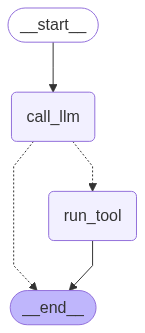

In [ ]:
from IPython.display import Image, display
try:
  #우리가 만든 app의 graph를 이미지로 그려서 display()로 감싸 출력하는 함수
  display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
  pass

In [ ]:
result = app.invoke({"messages": [{"role": "user", "content": "Draft a response to my coworker(jeongeunswd@gmail) confirming that I want to attend Interrupt!"}]})
for m in result["messages"]:
    m.pretty_print()

================================ Human Message =================================

Draft a response to my coworker(jeongeunswd@gmail) confirming that I want to attend Interrupt!
================================== Ai Message ==================================
Tool Calls:
  write_email (call_g1wGQley82x1pH8rgfmLoC2S)
 Call ID: call_g1wGQley82x1pH8rgfmLoC2S
  Args:
    to: jeongeunswd@gmail
    subject: Re: Interrupt! Attendance Confirmation
    content: Hi Jeongeun,

Thank you for the invitation! I’m confirming that I would like to attend Interrupt. Please let me know if there are any details I should be aware of or if there’s anything I need to prepare in advance.

Looking forward to it!

Best,
[Your Name]
================================= Tool Message =================================

Email sent to jeongeunswd@gmail with subejct Re: Interrupt! Attendance Confirmation and content Hi Jeongeun,

Thank you for the invitation! I’m confirming that I would like to attend Interrupt. Please let